In [1]:
import os 
import numpy as np 
import tensorflow as tf 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from matplotlib import patches

In [2]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

In [3]:
def from_coco_to_corner(boxes):
    """
        convert to xmin ymin xmax ymax
    """
    return tf.stack([
        boxes[:,1], 
        boxes[:,0], 
        boxes[:,3], 
        boxes[:,2]
    ], axis=-1)
    


def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.

    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.

    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """

    return tf.stack(
        [(boxes[:,0] + boxes[:, 2]) / 2,
        (boxes[:, 1] + boxes[:, 3]) / 2,
        boxes[:, 2] - boxes[:,0], 
        boxes[:, 3] - boxes[:, 1]], 
        axis=-1
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


In [4]:
def compute_iou(boxes1, boxes2):
    """Computes pairwise IOU matrix for given two sets of boxes

    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.

    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    
    # convert boxes to corners to compute iou 
    box1 = convert_to_corners(boxes1) 
    box2 = convert_to_corners(boxes2) 
    
    # for each gt bbox, compare it's (xmin,ymin) coords with each anchor 
    # comparing A with B with the following : A[:,None, xxxx] ; B[xxx,xx] 
    print("COMPUTE IOU BBOX",boxes1)
    print("COMPUTE IOU ANCHOR",boxes2)
    upper_left = tf.maximum(box1[:,None,:2], box2[:, :2]) 
    lower_down = tf.minimum(box1[:, None, 2:], box2[:, 2:]) 
    # if area of the intersection is < 0 => clip it to 0 
    area_dims = tf.maximum(0.0, lower_down - upper_left)
    intersection_area = upper_left[:,:,0] * lower_down[:,:,1] 
    # computing union between boxes 
    box1_union = box1[:,2:] - box1[:,:2] # compute width/height for each box 
    box2_union = box2[:,2:] - box2[:,:2] # *** 
    # compute all boxes union 
    box1_union = box1_union[:,0] * box1_union[:,1] 
    box2_union = box2_union[:,0] * box2_union[:,1] 
    # computing the total union 
    union_area = box1_union[:,None] + box2_union - intersection_area    
    # return the intersection over union 
    
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0) 

def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
    ):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [5]:
class Anchor: 
    
    def __init__(self): 
        self.aspect_ratios =  [0.2, 1, 2] 
        self.sizes = [2**i for i in [0, 1/3, 2/3]]
        self.num_anchors = len(self.aspect_ratios) * len(self.sizes) 
        self.areas = [x**2 for x in [32, 64, 128, 256, 512]]
        self.strides = [2**l for l in range(3,8)]
        self.dims = self._get_anchor_dims()
        
        
    def _get_anchor_dims(self): 
        
        all_dimensions = []
        
        # iterating over convs
        for area in self.areas: 
            dimensions = []
            # creating the 9 anchor boxes 
            for ratio in self.aspect_ratios: 
                    
                anchor_height = tf.math.sqrt(area/ratio)
                anchor_width = area / anchor_height 
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), 
                    [1,1,2]
                )
                for size in self.sizes: 
                    # scale down 
                    dimensions.append(dims*size)
            # append 2X9 tensors
            all_dimensions.append(tf.stack(dimensions, axis=-2))
        return all_dimensions
                    
    
    def _get_anchors(self, feature_height, feature_width, level): 
        
        # meshgrid 
        rx = tf.range(feature_width, dtype="float32") + 0.5
        ry = tf.range(feature_height, dtype="float32") + 0.5
        centers = tf.stack(tf.meshgrid(rx,ry), axis=-1) * self.strides[level-3] 
        centers = tf.expand_dims(centers, axis=-2) 
        centers = tf.tile(centers, [1,1,self.num_anchors,1])
        dims = tf.tile(self.dims[level-3], [feature_height, feature_width, 1,1])
        
        anchors= tf.concat([centers, dims], axis=-1)
        anchors = tf.reshape(anchors, (feature_height * feature_width * self.num_anchors,4))
        
        return anchors
    
    def get_anchors(self, image_height, image_width): 
        """
            get anchors for each convolution level/stride  on the image
        """
        
        anchors = [
            self._get_anchors(tf.math.ceil(image_height/2**stride),
                              tf.math.ceil(image_width/2**stride),
                              stride
            )
            for stride in range(3,8)
        ]
        print("FINAL anchors shape", tf.concat(anchors, axis=0))
        return tf.concat(anchors, axis=0)
        
        
    
    

In [6]:
anchor = Anchor()
anchor._get_anchors(2, 2, 3)

<tf.Tensor: shape=(36, 4), dtype=float32, numpy=
array([[  4.      ,   4.      ,  14.310837,  71.55417 ],
       [  4.      ,   4.      ,  18.030525,  90.1526  ],
       [  4.      ,   4.      ,  22.717037, 113.58516 ],
       [  4.      ,   4.      ,  32.      ,  32.      ],
       [  4.      ,   4.      ,  40.317474,  40.317474],
       [  4.      ,   4.      ,  50.796833,  50.796833],
       [  4.      ,   4.      ,  45.254833,  22.627417],
       [  4.      ,   4.      ,  57.017517,  28.508759],
       [  4.      ,   4.      ,  71.83757 ,  35.918785],
       [ 12.      ,   4.      ,  14.310837,  71.55417 ],
       [ 12.      ,   4.      ,  18.030525,  90.1526  ],
       [ 12.      ,   4.      ,  22.717037, 113.58516 ],
       [ 12.      ,   4.      ,  32.      ,  32.      ],
       [ 12.      ,   4.      ,  40.317474,  40.317474],
       [ 12.      ,   4.      ,  50.796833,  50.796833],
       [ 12.      ,   4.      ,  45.254833,  22.627417],
       [ 12.      ,   4.      ,  57.017

In [7]:
def preprocess_data(sample): 
    """
        preprocessing for a single sample 
    """
    image = sample["image"] 
    bbox = from_coco_to_corner(sample["objects"]["bbox"]) 
    cls_id = sample["objects"]["label"]
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    #scaling bbox coords
    bbox = tf.stack([
        bbox[:,0] * image_shape[1], 
        bbox[:,1] * image_shape[0], 
        bbox[:,2] * image_shape[1], 
        bbox[:,3] * image_shape[0]
    ], axis=-1)
    
    print(bbox)
    # convert box to xywh
    bbox = convert_to_xywh(bbox) 
    
    return image, bbox, cls_id
    
    

tf.Tensor(
[[151.06     353.505    129.78     204.53001 ]
 [450.88     302.97     238.88     137.39998 ]
 [260.13     226.04      47.020004 150.4     ]], shape=(3, 4), dtype=float32)


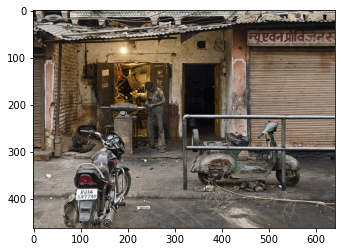

In [8]:
for sample in train_dataset.take(30): 
    image = sample["image"]
    bbox = from_coco_to_corner(sample["objects"]["bbox"])
    height, width = image.shape[:2]
    bbox = tf.stack([
        bbox[:,0] * width, 
        bbox[:,1] * height, 
        bbox[:,2] * width, 
        bbox[:,3] * height
    ], axis=-1)
    
    print(convert_to_xywh(bbox))
    plt.imshow(image)
    break
    

In [9]:
class LabelEncoder: 
    """
        this class aims at encoding a raw sample into a training input and target 
    """
    
    def __init__(self): 
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )
    
    def _match_anchors(self, bbox, anchors,match_iou=0.5, ignore_iou=0.4): 
        """
            matches ground truth bbox to anchors 
        """ 
        # compute the iou matrix
        print("bbox", bbox)
        print("anchors", anchors)
        iou_matrix = compute_iou(anchors, bbox) 
        # we want to associate one bbox to an anchor 
        # if we have 3 bbox and 10 anchors, we want to have a (3, 10) (3 lines of 10 columns
        # if the colmun value is 1, the bbox matches the actual anchor (anchor number : column number) 
        # then, we grab the corresponding anchor and build the target data 
        
        # compute max iou for each row and consider all anchors with lower iou as background / ignored 
        max_iou = tf.reduce_max(iou_matrix, axis=1) 
        # get matching anchors 
        matched_anchors = tf.argmax(iou_matrix, axis=1) 
        # negative examples 
        negative_examples = tf.math.less(max_iou, match_iou)
        positive_examples = tf.math.greater_equal(max_iou, match_iou)
        ignored_examples = tf.math.logical_not(tf.math.logical_or(negative_examples, positive_examples))
        return matched_anchors, tf.cast(positive_examples, dtype="float32"), tf.cast(ignored_examples, dtype="float32")
    
    def _compute_box_target(self, bbox, anchor): 
        """
            compute box target for training 
        """
        txy = (anchor[:,:2] - bbox[:,:2]) / anchor[:,2:]
        twh = tf.math.log(anchor[:,2:] / bbox[:,2:])

        target_bbox = tf.concat([txy, twh], axis=-1)
        return target_bbox 


    def _encode_sample(self, image_shape, bbox, class_ids):
        # generate anchor boxes for a given 
        anchors = Anchor().get_anchors(image_shape[0], image_shape[1])
        # compute iou 
        matched_anchors_idx, positive_examples, ignored_examples = self._match_anchors(bbox, anchors)
        positive_examples = tf.cast(positive_examples, dtype=tf.int64) 
        ignored_examples = tf.cast(positive_examples, dtype=tf.int64)
        matched_gt_box = tf.gather(bbox, matched_anchors_idx) # array of gt boxes 
        #compute targets 
        box_target = self._compute_box_target(matched_gt_box, anchors)
        # associate labels 
        # get all labels 
        matched_gt_class_ids = tf.gather(class_ids, matched_anchors_idx)
        print(matched_gt_class_ids)
        print("POSTIIVE sample DTYPE", positive_examples) 
        print("MATCHED GT CLASS DTYPE", matched_gt_class_ids)
        print("THE CONDITION DTYPE", tf.math.not_equal(positive_examples, 1))
        class_target = tf.where(
            tf.math.not_equal(positive_examples, 1), 
            tf.cast(-1, dtype=tf.int64), 
            tf.cast(matched_gt_class_ids, dtype=tf.int64)
        )
        class_target = tf.where(
            tf.math.equal(ignored_examples, 1), 
            tf.cast(-2, dtype=tf.int64), 
            tf.cast(class_target, dtype=tf.int64)
        )
        class_target = tf.expand_dims(class_target, axis=-1)
        label = tf.concat([box_target, tf.cast(class_target, dtype="float32")],axis=-1)
        print("label", label.shape) 
        
        return label
    
    def encode_batch(self, batch_images, gt_boxes, gt_ids): 
        """
            create targets from a batch of images
        """
        
        batch_size = tf.shape(batch_images)[0]
        
        labels = tf.TensorArray(dtype=tf.float64,size=batch_size,dynamic_size=True)
    
        for idx in range(batch_size): 
            for i in range(10): 
                print()
            print("BATCH NUMBER", idx) 
            for i in range(10): 
                print()
            # grab image, gt_boxes, gt_ids 
            image = batch_images[0, :,:]
            print("BATCH IMAGE", batch_images)
            print("GT BOX FOR SPECIFIC IMAGE", gt_boxes[idx])
            label = self._encode_sample(tf.shape(image), gt_boxes[idx], gt_ids[idx]) 
            labels = labels.write(idx, label) 
            image = tf.keras.applications.resnet50.preprocess_input(image)
        print("FINAL LABEL STACK", labels.stack().shape)
        return batch_images, labels.stack()
            
        


In [12]:
def visualize_test(): 
    data = train_dataset.take(1)
    data = list(data.as_numpy_iterator())[0]
    image = data["image"] 
    height, width = image.shape[:2]
    bbox = swap_xy(data["objects"]["bbox"])
    # scaling the bbox to the image 
    bbox = tf.stack([bbox[:,0] * width, bbox[:,1] * height, (bbox[:,2] - bbox[:, 0]) * width, (bbox[:,3] - bbox[:,1]) * height], axis=-1)
    cls = data["objects"]["label"] 

    # anchor 
    anchor = Anchor()
    image_anchors = anchor.get_anchors(width,height)[:10]
    iou_matrix = compute_iou(bbox, image_anchors)
    fig, ax = plt.subplots(figsize=(12,10))
    
    label_encoder = LabelEncoder()
    label_encoder._encode_sample((height, width), bbox, cls)
    
    print() 
    print()
    
    
    
    
    for box in bbox: 
        
        rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=4, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    print("IMAGE SHAPE", image.shape)
    plt.imshow(image) 
    plt.show()
    
    

FINAL anchors shape tf.Tensor(
[[   4.          4.         14.310837   71.55417 ]
 [   4.          4.         18.030525   90.1526  ]
 [   4.          4.         22.717037  113.58516 ]
 ...
 [ 448.        576.        724.07733   362.03867 ]
 [ 448.        576.        912.2803    456.14014 ]
 [ 448.        576.       1149.4011    574.70056 ]], shape=(55800, 4), dtype=float32)
COMPUTE IOU BBOX tf.Tensor(
[[ 86.17     251.24     129.78     204.53    ]
 [331.44     234.27     238.88     137.39998 ]
 [236.62001  150.84      47.019997 150.40001 ]], shape=(3, 4), dtype=float32)
COMPUTE IOU ANCHOR tf.Tensor(
[[  4.         4.        14.310837  71.55417 ]
 [  4.         4.        18.030525  90.1526  ]
 [  4.         4.        22.717037 113.58516 ]
 [  4.         4.        32.        32.      ]
 [  4.         4.        40.317474  40.317474]
 [  4.         4.        50.796833  50.796833]
 [  4.         4.        45.254833  22.627417]
 [  4.         4.        57.017517  28.508759]
 [  4.         4.

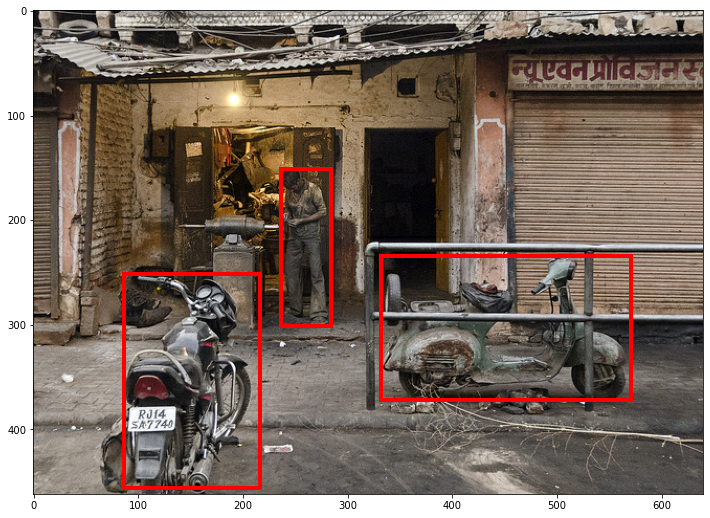

In [13]:
visualize_test()

In [14]:
def get_backbone(nb_classes): 
    """
        load resnet50 and extract P3 to P7 convolution layers
    """
    
    backbone = tf.keras.applications.ResNet50(
        include_top=False, 
        weights="imagenet",
        input_shape=(224, 224, 3),
        classes=nb_classes
    )
    
    backbone.summary()
    
    # store output
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output 
        for layer_name in ["conv3_block4_out", "conv4_block4_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output])
    

In [15]:
model = get_backbone(80)
print(model)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
class FeaturePyramidLayer(tf.keras.layers.Layer): 

    def __init__(self, nb_classes): 
        super(FeaturePyramidLayer, self).__init__()
        self.backbone = get_backbone(nb_classes)
        self.c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, padding="same") 
        self.c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, padding="same") 
        self.c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, padding="same") 
        self.c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, padding="same") 
        self.c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, padding="same") 
        self.c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, padding="same") 
        self.c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2)
        self.c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, activation="relu")
        self.upsampling_layer = tf.keras.layers.UpSampling2D(2)
        
    def call(self, image, training=False): 
        c3_output, c4_output, c5_output = self.backbone(image, training=False)
        p4_1x1 = self.c4_1x1(c4_output)
        p3_1x1 = self.c3_1x1(c3_output)
        
        p5_out_pre = self.c5_1x1(c5_output)
        p4_out_pre = self.upsampling_layer(p5_out_pre) + p4_1x1 
        p3_out_pre = self.upsampling_layer(p4_out_pre) + p3_1x1
        
        p4_out = self.c4_3x3(p4_out_pre)
        p3_out = self.c3_3x3(p3_out_pre) 
        p5_out = self.c5_3x3(p5_out_pre)
        p6_out = self.c6_3x3(c5_output)
        p7_out = self.c7_3x3(p6_out)
        return p3_out, p4_out, p5_out, p6_out, p7_out
    
    
def build_head(output_filters): 
    
    inputs = tf.keras.Input(shape=[None, None, 256])
    x = inputs
    for i in range(4): 
        x = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x) 
        
    # final layer 
    x = tf.keras.layers.Conv2D(output_filters, 3, padding="same")(x) 
    
    return tf.keras.Model(inputs=[inputs], outputs=[x])
    


In [17]:
class Retinanet(tf.keras.Model): 
    
    def __init__(self, nb_classes): 
        super(Retinanet, self).__init__()
        self.nb_classes = nb_classes
        self.fpn =  FeaturePyramidLayer(self.nb_classes)
        self.regression_head = build_head(9*4)
        self.clf_head = build_head(9*self.nb_classes)
        
    def call(self, image): 
        # custom forward pass 
        # use the fpn network 
        N = tf.shape(image)[0]
        features = self.fpn(image)
        regr_out, clf_out = [], [] 
        
        print("Iterating over all features")
        for feature in features:
            regr_out.append(
                tf.reshape(self.regression_head(feature), [N,-1,4])
            )
            
            clf_out.append(
                tf.reshape(self.clf_head(feature), [N,-1,self.nb_classes])
            )
        
        print("CALCULATED ALL LOSSES !")
        
        print("GETTING READY FOR CONCAT")
        regr_out = tf.concat(regr_out, axis=1) 
        clf_out = tf.concat(clf_out, axis=1)
        
        print("RETURNING FINAL TENSOR ", tf.concat([clf_out, regr_out], axis=-1))
        return tf.concat([clf_out, regr_out], axis=-1)
        
        

In [18]:
# testing the retinanet call layer 

inputs = tf.keras.Input(shape=[224,224,3], batch_size=28) 
outputs = Retinanet(80).call(inputs)
print(outputs)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Iterating over all features
CALCULATED ALL LOSSES !
GETTING READY FOR CONCAT
RETURNING FINAL TENSOR  KerasTensor(type_spec=TensorSpec(shape=(28, 9351, 84), dtype=tf.float32, name=None), name='tf.concat_2/concat:0', description="created by layer 'tf.concat_2'")
KerasTensor(type_spec=TensorSpec(shape=(28, 9351, 84), dtype=tf.float32, name=None), name='tf.concat_3/concat:0', description="created by layer 'tf.concat_3'")


In [19]:
class SmoothL1Loss(tf.keras.losses.Loss): 
    
    def __init__(self): 
        super(SmoothL1Loss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        
    def call(self, y_true, y_pred): 
        difference = y_pred - y_true
        absolute_difference =  tf.math.abs(difference)
        squared_difference = difference **2
        
        loss = tf.where(
            absolute_difference < 1, 
            0.5*squared_difference, 
            absolute_difference - 0.5
        )
        
        return tf.reduce_sum(loss, axis=-1)
        
        
        
class FocalLoss(tf.keras.losses.Loss): 
    
    def __init__(self, gamma, alpha): 
        super(FocalLoss, self).__init__(
            reduction="none", name="RetinaNetClfLoss"
        )
        self.gamma = gamma 
        self.alpha = alpha
    
    def call(self, y_true, y_pred): 
        
        preds =  tf.keras.activations.sigmoid(y_pred)
        props = tf.keras.losses.CategoricalCrossentropy()(y_true,preds)
        pt = tf.where(tf.math.not_equal(y_true, 1.0), 1-preds, preds)
        loss = self.alpha * tf.pow((1-pt), self.gamma) * tf.math.log(pt) 
        return tf.reduce_sum(loss, axis=1)
    
    
class RetinaNetLoss(tf.keras.losses.Loss): 
    
    def __init__(self, nb_classes, alpha=0.25, gamma=2.0):
        super(RetinaNetLoss, self).__init__(
            reduction="none", name="RetinaNetLoss"
        )
        self.nb_classes = nb_classes 
        self.alpha = alpha 
        self.gamma = gamma 
        self.regr_loss = SmoothL1Loss()
        self.focal_loss = FocalLoss(gamma, alpha)

    def call(self, y_true, y_pred): 
        
        true_bbox = y_true[:,:,:4] 
        pred_bbox = y_pred[:,:,:4] 
        
        true_clf = tf.one_hot(
            tf.cast(y_true[:,:,4], dtype=tf.int32), 
            depth=self.nb_classes
        )
        
        pred_clf = y_pred[:,:,4:]
        
        positive_masks = tf.cast(tf.math.greater(pred_clf, -1.0), dtype="int32")
        ignore_masks = tf.cast(tf.math.equal(pred_clf, -2.0), dtype="int32") 
        
        # box loss 
        box_loss = self.regr_loss(true_bbox, pred_bbox) 
        focal_loss = self.focal_loss(true_clf, pred_clf)
        
        # if negative mask, box loss = 0 
        print("DTYPE BOX LOSS", box_loss.dtype) 
        print("DTYPE", tf.math.equal(ignore_masks,1).dtype)
        focal_loss = tf.where(tf.math.equal(ignore_masks,1), 0.0, box_loss)
        box_loss = tf.where(tf.math.not_equal(positive_masks, 1), box_loss, 0) 
        
        normalizer = tf.cast(tf.reduce_sum(positive_masks, axis=-1), dtype=tf.float32)
        print("DTYPE FOCAL LOSS", focal_loss.dtype) 
        print("DTYPE NORMALIZER", normalizer.dtype)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(focal_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        print("COMPUTED ALL LOSSES")
        loss = clf_loss + box_loss
        print("ADDING ALL LOSSES ! ")
        
        return loss


In [20]:
model_dir = "retinanet_model_dir/"
label_encoder = LabelEncoder()

num_classes = 80
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

In [21]:
resnet50_backbone = get_backbone(num_classes)
loss_fn = RetinaNetLoss(num_classes)
model = Retinanet(num_classes)

optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [22]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

In [23]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

In [24]:
autotune = tf.data.AUTOTUNE


train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(batch_size)

Tensor("stack_1:0", shape=(None, 4), dtype=float32)


In [25]:
train_dataset = train_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)












BATCH NUMBER Tensor("while/Placeholder:0", shape=(), dtype=int32)










BATCH IMAGE Tensor("args_0:0", shape=(None, None, None, 3), dtype=uint8)
GT BOX FOR SPECIFIC IMAGE Tensor("while/strided_slice_1:0", shape=(None, 4), dtype=float32)
FINAL anchors shape Tensor("while/concat_5:0", shape=(None, 4), dtype=float32)
bbox Tensor("while/strided_slice_2:0", shape=(None, 4), dtype=float32)
anchors Tensor("while/concat_6:0", shape=(None, 4), dtype=float32)
COMPUTE IOU BBOX Tensor("while/concat_6:0", shape=(None, 4), dtype=float32)
COMPUTE IOU ANCHOR Tensor("while/strided_slice_2:0", shape=(None, 4), dtype=float32)
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Tensor("while/GatherV2_1:0", shape=(None,), dtype=int64)
POSTIIVE sample DTYPE Tensor("while/Cast_2:0", shape=(None,), dtype=int64)
MATCHED GT CLASS DTYPE Tensor("while/GatherV2_1:0", shape=(None,), dtype=int64)
THE CONDITION DTYPE Tensor("while/NotEqual:0", shape=(None,), dtype=bool)
label (None, 5)
ERROR:tensorflow:Error: Input value Tensor("while/concat_10:0", shape=(None, 5), dtype=float32) has dtype <dtype: 'float32'>, but expected dtype <dtype: 'float64'>.  This leads to undefined behavior and will be an error in future versions of TensorFlow.  Traceback:
  File "/home/valentin/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/valentin/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/valentin/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/valentin/anaconda3/lib/python3.8/sit

ERROR:tensorflow:Error: Input value Tensor("while/concat_10:0", shape=(None, 5), dtype=float32) has dtype <dtype: 'float32'>, but expected dtype <dtype: 'float64'>.  This leads to undefined behavior and will be an error in future versions of TensorFlow.  Traceback:
  File "/home/valentin/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/valentin/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/valentin/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/valentin/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/valentin/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/home/valentin/anaconda3/lib/python3.8/site-packages/tornado/platform/asyn

FINAL LABEL STACK (None, None, 5)


In [26]:
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.shuffle(8 * batch_size)
val_dataset = val_dataset.padded_batch(batch_size)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)


Tensor("stack_1:0", shape=(None, 4), dtype=float32)










BATCH NUMBER Tensor("while/Placeholder:0", shape=(), dtype=int32)










BATCH IMAGE Tensor("args_0:0", shape=(None, None, None, 3), dtype=uint8)
GT BOX FOR SPECIFIC IMAGE Tensor("while/strided_slice_1:0", shape=(None, 4), dtype=float32)
FINAL anchors shape Tensor("while/concat_5:0", shape=(None, 4), dtype=float32)
bbox Tensor("while/strided_slice_2:0", shape=(None, 4), dtype=float32)
anchors Tensor("while/concat_6:0", shape=(None, 4), dtype=float32)
COMPUTE IOU BBOX Tensor("while/concat_6:0", shape=(None, 4), dtype=float32)
COMPUTE IOU ANCHOR Tensor("while/strided_slice_2:0", shape=(None, 4), dtype=float32)
Tensor("while/GatherV2_1:0", shape=(None,), dtype=int64)
POSTIIVE sample DTYPE Tensor("while/Cast_2:0", shape=(None,), dtype=int64)
MATCHED GT CLASS DTYPE Tensor("while/GatherV2_1:0", shape=(None,), dtype=int64)
THE CONDITION DTYPE Tensor("while/NotEqual:0", shape=(None,), dtype=bool)
label (None, 5)
ERROR:tensorflow:

ERROR:tensorflow:Error: Input value Tensor("while/concat_10:0", shape=(None, 5), dtype=float32) has dtype <dtype: 'float32'>, but expected dtype <dtype: 'float64'>.  This leads to undefined behavior and will be an error in future versions of TensorFlow.  Traceback:
  File "/home/valentin/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/valentin/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/valentin/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/valentin/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/valentin/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/home/valentin/anaconda3/lib/python3.8/site-packages/tornado/platform/asyn

FINAL LABEL STACK (None, None, 5)


In [27]:
epochs = 1

model.fit(
    train_dataset.take(100),
    validation_data=val_dataset.take(50),
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

Iterating over all features
CALCULATED ALL LOSSES !
GETTING READY FOR CONCAT
RETURNING FINAL TENSOR  Tensor("retinanet_1/concat_2:0", shape=(None, None, 84), dtype=float32)
DTYPE BOX LOSS <dtype: 'float32'>
DTYPE <dtype: 'bool'>
DTYPE FOCAL LOSS <dtype: 'float32'>
DTYPE NORMALIZER <dtype: 'float32'>
COMPUTED ALL LOSSES
ADDING ALL LOSSES ! 
Iterating over all features
CALCULATED ALL LOSSES !
GETTING READY FOR CONCAT
RETURNING FINAL TENSOR  Tensor("retinanet_1/concat_2:0", shape=(None, None, 84), dtype=float32)
DTYPE BOX LOSS <dtype: 'float32'>
DTYPE <dtype: 'bool'>
DTYPE FOCAL LOSS <dtype: 'float32'>
DTYPE NORMALIZER <dtype: 'float32'>
COMPUTED ALL LOSSES
ADDING ALL LOSSES ! 


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Invalid data types; op elements float but list elements double
	 [[{{node while/body/_1/while/TensorArrayV2Write/TensorListSetItem}}]]
	 [[IteratorGetNext]]
  (1) Invalid argument:  Invalid data types; op elements float but list elements double
	 [[{{node while/body/_1/while/TensorArrayV2Write/TensorListSetItem}}]]
	 [[IteratorGetNext]]
	 [[retinanet_1/Shape/_6]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_30405]

Function call stack:
train_function -> train_function


In [ ]:
for item in train_dataset.take(3).as_numpy_iterator(): 
    print(item)